# D. Skill assessment (CRPSS calculation)

Since the seasonal forecasts are comprised of ensemble members, generally applied simple evaluation methods such as RMSE (Root Mean Squared Error) and R2 have limitations. 
Thus, in this code, CRPS or CRPSS are adopted to measure the skill of ensembled datasets.
This code enables you to calculate those indices automatically.

## 1. Import Libraries

Let's start by importing the necessary libraries (🚨 in order to run the code like in the cell below, place the mouse pointer in the cell, then click on “run cell” button above or press shift + enter).

In [4]:
import cdsapi
import netCDF4
from netCDF4 import num2date, Dataset
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import os
import pandas as pd
import hydrostats.ens_metrics as em
import datetime
from matplotlib.colors import ListedColormap

## 2. Settings

Define the basic settings in calculating CRPS and CRPSS.

In [5]:
originating_centre = 'ECMWF'  # Define the provider of Seasonal Meteorological Forecasts
variable = 'tp'               # Information that you want to calculate areal mean
catch_name = 'A'              # What is the name of your catchment?
maxleadtime = 6               # Number of months that you want to extract
start_year = 2011             # CRPS/CRPSS calculation start year
end_year = 2020               # CRPS/CRPSS calculation end year
start_month = 1               # CRPS/CRPSS calculation start month
end_month = 12                # CRPS/CRPSS calculation end month
days = {1:31,2:28,3:31,4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30,12:31}

inpath = './assessment/' + str(originating_centre.upper())+ '/daily/'
bcpath = './assessment/' + str(originating_centre.upper())+ '/biascorrection/'
calcpath = './assessment/' + str(originating_centre.upper())+ '/calculation/'

## 3. Seasonal forecasts CRPS calculation

###   3.1 Rearrange Datasets by lead time (Seasonal forecasts)

Basically, CRPS/CRPSS are calculated according to lead time. Therefore, we need to collect them into a single file for each lead time. This code enable to collect every data having same lead time. 

Considering that we have 2 types datasets, before and after bias correction, <font color = 'red'> You don't need to repeat this process 2 times, since automatically this code perforems for both.</font> 

In [7]:
# Bias correction type
bctype = {1:'before',2:'after'}

# Allocation of inputfile path and tail annotation
for bc_i in range(1,3):
    for leadtime in range(1,maxleadtime+1):
        for years in range(start_year,end_year+1):
            for months in range(start_month, end_month+1):
                if bc_i == 1:
                    path = inpath
                    tail = ''
                else:
                    path = bcpath
                    tail = '_bc'
                df = pd.read_csv(path + str(catch_name) + '_' + str(years) + '_' + str(months).zfill(2) + '_' 
                                 + str(originating_centre.lower())+ '_' + str(variable) + tail + '.csv')
                df2=df.groupby(by=['leadtime']).sum().cumsum()
                df2['date'] = str(years) + '_' + str(months)
                col1=df2.columns[-1:].to_list()
                col2=df2.columns[:-1].to_list()
                new_col=col1+col2
                df3=df2[new_col]
                temp = pd.DataFrame(df3.loc[leadtime]).T
                if years == start_year and months ==start_month:
                    temp1 = temp
                else :
                    pass
                temp1 = pd.concat([temp1, temp], ignore_index=True)
        temp1 = temp1.iloc[1:]
        temp1['mean2'] = temp1['mean']
        temp1['obs2'] = temp1['obs']
        temp1=temp1.drop(['mean','obs'], axis=1)
        temp1.rename(columns={'mean2':'mean', 'obs2':'obs'}, inplace=True)
        temp1.set_index('date', inplace=True)
        temp1.to_csv(calcpath + str(catch_name) + '_' + str(leadtime) + '_' + bctype[bc_i] + '_bc.csv')

print('Successful')

Successful


### 3.2 CRPS calculation (Seasonal forecasts)

CRPS is a measure of how good forecasts are in matching observed outcomes considering each ensemble. It is a quadratic measure of the difference between the forecast cumulative distribution function (CDF) and the reference dataset of the observation (Zamo and Naveau, 2017). The CRPS is thus calculated as

$$ CRPS= \int [F(x) - H(x > y)]^2 dx $$

where F(x) represents the cumulative distribution of seasonal forecasts, y is observed precipitation, H is called the indicator function which is equals to 1 when x > y and 0 when x < y. Once the CRPS is equals to 0, the forecast is wholly accurate, conversely, the higher the CRPS, the worse the performance of the forecast. 

This code automatically calculate two times (before, after bias correction).

Also, sometimes we can face the issue from the number of ensemble members. Most of originating centres have changed number of ensemble members once. (Please see A.Download seasonal forecasts datasets / 3. Seasonal forecasts systems and datasets for 8 originating centres / Total precipitation table). In this case, we need to designate exact location and number of ensemble manually. 

This example show you the case when we apply ECMWF datasets to calculate CRPS from 2011 to 2020. In this case, there are 25 ensemble members and 72 rows from Jan.2011 to Dec.2016, also rest of the data have 51 ensemble members. If the number of ensemble members is same, you can put the same number on it.  <font color='red'> Remember, you need to manually to revise the code below;</font>

In [8]:
# Before bias correction
bctype = {1:'before',2:'after'}

# (Should be manually revised) 
num_row1 = 72    # The number of rows for the first datasets having 'num_col1' of ensemble members
num_col1 = 25    # The number of ensemble members for the first datasets
num_col2 = 51    # The number of ensemble members for the second datasets

# CRPS calculation
for bc_i in range(1,3):
    for leadtime in range(1,maxleadtime+1):
        df = pd.read_csv(calcpath + str(catch_name) + '_' + str(leadtime) + '_' + bctype[bc_i] + '_bc.csv')
        df_a = df.to_numpy().astype(float)
        df_a2 = df_a[:,1:df_a.shape[1]-2]
        df_a3 = df_a2[:num_row1, :num_col1]     # data slicing
        df_a4 = df_a2[num_row1:, :num_col2]     # data slicing
        df_obs1 = df_a[:num_row1, num_col2+2]   # data slicing
        df_obs2 = df_a[num_row1:, num_col2+2]   # data slicing
        
        crps_dictionary_rand1 = em.ens_crps(df_obs1, df_a3)
        crps_dictionary_rand2 = em.ens_crps(df_obs2, df_a4)
        temp1 = crps_dictionary_rand1['crps']
        temp2 = crps_dictionary_rand2['crps']
        crps = np.concatenate([temp1, temp2], axis=0)
        csv = pd.DataFrame(crps)
        csv['month'] = df['date'].str.slice(start=5,stop=7)
        csv.set_index(df['date'], inplace=True)
        csv=csv[['month',0]]
        csv=csv.rename(columns={0:'CRPS_'+str(leadtime)})
        csv.to_csv(calcpath + 'CRPS_' + str(leadtime) + '_' + str(catch_name) +'_' + bctype[bc_i] + '_bc.csv')
    leadtime = leadtime+1

# Data merge for whole lead time
    base = pd.read_csv(calcpath + 'CRPS_' + str(1) + '_' + str(catch_name) +'_' + bctype[bc_i] + '_bc.csv')
    base['leadtime'] = 1
    base['CRPS'] = round(base['CRPS_1'],3)
    base.drop(columns=['CRPS_1'], inplace=True)
    for leadtime in range(2,maxleadtime+1):
        df = pd.read_csv(calcpath + 'CRPS_' + str(leadtime) + '_' + str(catch_name) +'_' + bctype[bc_i] + '_bc.csv')
        df['CRPS'] = round(df['CRPS_' + str(leadtime)],3)
        df.drop(columns=['CRPS_' + str(leadtime)], inplace=True)
        df['leadtime'] = leadtime        
        base = pd.concat([base, df])
    leadtime = leadtime+1
    base['catchment'] = str(catch_name)
    base.set_index('catchment', inplace=True)
    base.to_csv(calcpath + '[CRPS]_' + str(catch_name) +'_'  + str(originating_centre.lower()) + '_' + bctype[bc_i] + '_bc.csv')

print('Successful')

Successful


## 4. Climatology CRPS calculation


### 4.1 Rearrange Datasets by lead time (climatology)

To calculate CRPSS, you should calculate the CRPSS of climatology as a benchmark. Here, climatology represents the past observed precipitation. 
Once again, to calculate CRPS, we need to rearrange the datasets along with lead time. To run the code, firstly you should specify the earliest year that you have as climatology.

In [9]:
start_year_cli = 1993  # The earliest year that you have historical data to calculate climatology ensembles.

# Call the observed data (climatology) and basic treatment
leadtime=1
df = pd.read_csv('./assessment/obsdata_tp.csv')
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True, format='%m/%d/%Y', errors='ignore')
df['year']=df['date'].dt.year
df['month']=df['date'].dt.month
df2=df.groupby(['year', 'month']).sum()
df2=df2.reset_index()
df2=df2[df2['year']<=start_year]
df2=df2.pivot_table(str(catch_name), ['month'], 'year')
df2=df2.reset_index()

df3 = pd.read_csv(calcpath + str(catch_name) + '_' + str(1) + '_before_bc.csv')

# Data rearranging work for 1 month of lead time
empty_df = pd.DataFrame()
empty_df['date'] = df3['date']
for i in range(start_year_cli, start_year):
    empty_df[i] = df2[i]

for j in range(12, empty_df.shape[0]):
    empty_df.iloc[j] = empty_df.iloc[j-12]
j=j+1
empty_df['mean'] = round(empty_df.iloc[:,1:empty_df.shape[1]+2].mean(axis=1),2)
empty_df['obs'] = df3['obs']
empty_df['date'] = df3['date']
empty_df.set_index('date', inplace=True)
empty_df.to_csv(calcpath + str(catch_name) + '_' + str(leadtime) +'_climatology.csv')

# Rearranging data for the other lead times
df_cli = pd.read_csv(calcpath + str(catch_name) + '_' + str(1) +'_climatology.csv')
for leadtime in range(2,maxleadtime+1):
    empty_df_cli = df_cli
    num_row = empty_df_cli.shape[0]
    for m in range(1,maxleadtime):
        empty_df_cli.loc[num_row+m] = empty_df_cli.loc[m-1]
    m = m+1
    for k in range(0, num_row):
        empty_df_cli.iloc[k] = empty_df_cli.iloc[k:k+leadtime].sum()
    k=k+1
    empty_df_cli=empty_df_cli.loc[:num_row]
    df_cli = pd.read_csv(calcpath + str(catch_name) + '_' + str(1) +'_climatology.csv')
    empty_df_cli['date'] = df_cli['date']
    empty_df_cli.set_index('date', inplace=True)
    empty_df_cli.to_csv(calcpath + str(catch_name) + '_' + str(leadtime) +'_climatology.csv')
leadtime=leadtime+1

print('Successful')

Successful


#### 4.2 CRPS calculation (climatology)

This code repeats the process 3.2 for climatology.

In [10]:
# CRPS calculation
for leadtime in range(1,maxleadtime+1):
    df = pd.read_csv(calcpath + str(catch_name) + '_' + str(leadtime) + '_climatology.csv')
    df_a = df.to_numpy().astype(float)
    df_a2 = df_a[:,1:df_a.shape[1]-2]
    df_a3 = df_a2[:, :]   
    df_obs1 = df_a[:, df_a.shape[1]-1]   # 0에서 72번 행까지 / 53번 컬럼값을 선택하기
    crps_dictionary_rand1 = em.ens_crps(df_obs1, df_a3)
    temp1 = crps_dictionary_rand1['crps']
    csv = pd.DataFrame(temp1)
    csv['month'] = df['date'].str.slice(start=5,stop=7)
    csv.set_index(df['date'], inplace=True)
    csv=csv[['month',0]]
    csv=csv.rename(columns={0:'CRPS_'+str(leadtime)})
    csv.to_csv(calcpath + 'CRPS_' + str(leadtime) + '_' + str(catch_name) +'_climatology.csv')
leadtime = leadtime+1

# Data merge for whole lead time
base = pd.read_csv(calcpath + 'CRPS_' + str(1) + '_' + str(catch_name) +'_climatology.csv')
base['leadtime'] = 1
base['CRPS_ref'] = base['CRPS_1']
base.drop(columns=['CRPS_1'], inplace=True)
for leadtime in range(2,maxleadtime+1):
    df = pd.read_csv(calcpath + 'CRPS_' + str(leadtime) + '_' + str(catch_name) +'_climatology.csv')
    df['CRPS_ref'] = round(df['CRPS_' + str(leadtime)],3)
    df.drop(columns=['CRPS_' + str(leadtime)], inplace=True)
    df['leadtime'] = leadtime        
    base = pd.concat([base, df])
leadtime = leadtime+1
base['catchment'] = str(catch_name)
base.set_index('catchment', inplace=True)
base.to_csv(calcpath + '[CRPS]_' + str(catch_name) +'_'  + str(originating_centre.lower()) + '_climatology.csv')

print('Successful')

Successful


## 5. CRPSS calculation

CRPSS compares the skill of seasonal forecasts with climatology, thus finally it can be simply calculated as 

$$ CRPSS=\ 1\ -\ \frac{{\rm CRPS}^{Sys}}{{\rm CRPS}^{Ref}}$$

where $CRPS^{Sys}$ is previously calculated $CRPS$ (seasonal forecasts), $CRPS^{Ref}$ represents the reference $CRPS$ obtained from climatology. When the skill score is higher (lower) than zero, the forecasting system is more (less) skilful than reference. When it is equal to zero, the system (seasonal forecasts) and the reference (Climatology) have equivalent skill. 

CRPSS can be calculated by runing the code below;

In [11]:
pd.options.mode.chained_assignment = None  # disable chained assignments

bctype = {1:'before',2:'after'}            # Bias correction type

# CRPS calculation
for bc_i in range(1,3):
    df = pd.read_csv(calcpath + '[CRPS]_'+ str(catch_name)  + '_' + str(originating_centre.lower()) + '_'  + bctype[bc_i] 
                     + '_bc.csv')
    df_ref = pd.read_csv(calcpath + '[CRPS]_'+ str(catch_name)  + '_' + str(originating_centre.lower()) + '_climatology.csv')
    df_cal = df.copy()
    df_cal['CRPS_ref'] = round(df_ref['CRPS_ref'],3)
    df_cal['CRPSS'] = round(1 - df_cal['CRPS'] / df_cal['CRPS_ref'],3)
    # Count as 1 if CRPSS is greater than 0 (Skilful than reference) : We are doing this job to calculate the chances of CRPSS
    df_cal['count'] = np.nan
    for i in range(0,len(df_cal)):
        if df_cal['CRPSS'][i] > 0:
            df_cal['count'][i] = 1
        else:
            df_cal['count'][i] = 0
    df_cal.set_index('catchment', inplace=True)
    df_cal.to_csv(calcpath + '[CRPSS]_' + str(catch_name) + '_' + str(originating_centre.lower()) + '_'  + bctype[bc_i] 
                  + '_bc.csv')

print('Successful')

Successful


## 6. Overall skill assessment

To deliver the skill assessment results more intuitively, we suggests Overall skill which is chances (%) to be skilful than climatology by counting all forecasts having greater CRPSS than zero, then dividing it with the total number of forecasts. 
This can be expressed as

$$ Overall \; skill \ =\frac{\sum_{i=1}^{N} \; [\; H \; (CRPSS_i) \; ]}{\rm N}$$

where N is a total number of forecasts, H is equals to 1 when CRPSS ≥ 0 and 0 when CRPSS < 0. Once the probability is greater (smaller) than 50%, seasonal forecasts are more (less) skilful than climatology. Sometimes average of CRPSS can be highly affected by the presence of a few abnormally high or low scores, thus, chances (%) have advantages to deliver results more clearly.

By runing this code, you can draw graphs representing chances(%) to be skilful than reference (in this case, climatology) before and after bias correction.

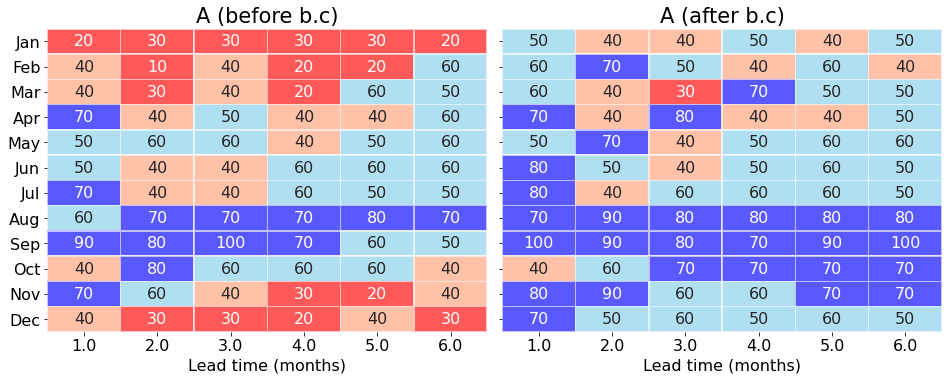

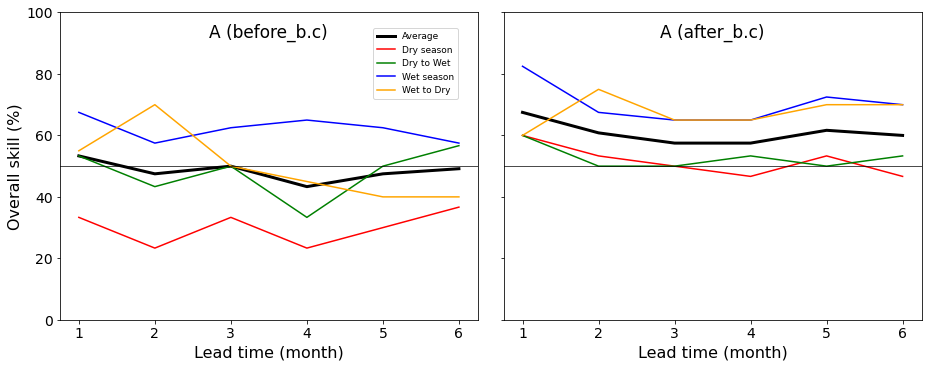

In [31]:
# Bias correction type
bctype = {1:'before',2:'after'}

for bc_i in range(1,3):
    df = pd.read_csv(calcpath + '[CRPSS]_' + str(catch_name) + '_' + str(originating_centre.lower()) + '_'  + bctype[bc_i] 
                     + '_bc.csv')
    count = df.reset_index().pivot_table("count", "month", "leadtime", aggfunc = "sum")
    f = count/(1*10)*100                                # probability calculation
    ff = f.reset_index().rename(columns={"Index":"a"})

    temp = pd.DataFrame()
    empty_df = pd.DataFrame()
    for lt in range(1,7):
        for i in range(0,len(ff)):
            month = ff['month'][i]
            leadtime = lt
            chances = ff[lt][i]
            empty_df = pd.DataFrame(columns = ['leadtime','month','chances'])
            empty_df.loc[i] = [leadtime, month, chances]
            temp = pd.concat([temp, empty_df], axis=0)
    df_f = temp
    df_f.reset_index(level=0, inplace=True)             # new dataset (probability) generation
    
    # Seasonal data gathering
    condition1 = (df_f.month == 12)|(df_f.month == 1)|(df_f.month == 2)
    condition2 = (df_f.month == 3)|(df_f.month == 4)|(df_f.month == 5)
    condition3 = (df_f.month == 6)|(df_f.month == 7)|(df_f.month == 8)|(df_f.month == 9)
    condition4 = (df_f.month == 10)|(df_f.month == 11)
    df_dry = df_f[condition1]
    df_t1 = df_f[condition2]
    df_wet = df_f[condition3]
    df_t2 = df_f[condition4]
    
    if bc_i == 1:
        df_f_1   = df_f
        df_dry_1 = df_dry
        df_t1_1  = df_t1
        df_wet_1 = df_wet
        df_t2_1  = df_t2
    else :
        df_f_2   = df_f
        df_dry_2 = df_dry
        df_t1_2  = df_t1
        df_wet_2 = df_wet
        df_t2_2  = df_t2

# Drawing figures
    
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(6.7*2, 5.5))
plt.subplot(1,2,1)
d1 = df_f_1.pivot_table("chances", "month", "leadtime", aggfunc = "sum")
d1['mon'] = pd.Series(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], index=[1,2,3,4,5,6,7,8,9,10,11,12])
d1.set_index('mon', inplace=True)
ax1 = sns.heatmap(d1, annot=True, cmap=ListedColormap(['red', 'lightsalmon', 'skyblue', 'blue']),
                  cbar_kws={'ticks': [35,50,65,80], 'extend': 'both'}, annot_kws={'fontsize': 16},
                  vmin=20, vmax=80, fmt='.0f',linewidth=0.5, cbar=False, alpha=0.65)
plt.title(str(catch_name) + ' (before b.c)', fontsize=21)
ax1.set_xlabel('Lead time (months)', fontsize=16)
ax1.set_ylabel(None)
plt.yticks(rotation=0, horizontalalignment='right', fontsize=16)
plt.xticks(fontsize=16)

plt.subplot(1,2,2)
d2 = df_f_2.pivot_table("chances", "month", "leadtime", aggfunc = "sum")
d2['mon'] = pd.Series(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], index=[1,2,3,4,5,6,7,8,9,10,11,12])
d2.set_index('mon', inplace=True)
ax1 = sns.heatmap(d2, annot=True, cmap=ListedColormap(['red', 'lightsalmon', 'skyblue', 'blue']),
                  cbar_kws={'ticks': [35,50,65,80], 'extend': 'both'}, annot_kws={'fontsize': 16},
                  vmin=20, vmax=80, fmt='.0f',linewidth=0.5, cbar=False, alpha=0.65)
plt.title(str(catch_name) + ' (after b.c)', fontsize=21)
ax1.set_xlabel('Lead time (months)', fontsize=16)
ax1.set_ylabel(None)
ax1.axes.yaxis.set_ticklabels([])
plt.yticks(rotation=0, horizontalalignment='right', fontsize=16)
plt.xticks(fontsize=16)
fig.tight_layout(pad=1.5)


fig, axes = plt.subplots(1, 2, sharex=False, figsize=(6.5*2, 5.2))
plt.subplot(1,2,1)
ax= sns.lineplot(x='leadtime', y='chances', color= 'black', data=df_f_1, ci=None, label = 'Average', linewidth = 3)
ax= sns.lineplot(x='leadtime', y='chances', color= 'red', data=df_dry_1, ci=None, label = 'Dry season')
ax= sns.lineplot(x='leadtime', y='chances', color= 'green', data=df_t1_1, ci=None, label = 'Dry to Wet')
ax= sns.lineplot(x='leadtime', y='chances', color= 'blue', data=df_wet_1, ci=None, label = 'Wet season')
ax= sns.lineplot(x='leadtime', y='chances', color= 'orange', data=df_t2_1, ci=None, label = 'Wet to Dry')
plt.legend(loc=(0.75,0.72), fontsize=9)
plt.xlabel('Lead time (month)', fontsize=16)
plt.ylabel('Overall skill (%)', fontsize=16)
plt.ylim(0,100)
plt.axhline(y=50, color='black', lw=1.0, alpha=0.7, linestyle='-')  #수평 중앙선 삽입하기
plt.title(str(catch_name) + ' (before_b.c)', x=0.5, y=0.9, fontsize = 17)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
    
plt.subplot(1,2,2)
ax= sns.lineplot(x='leadtime', y='chances', color= 'black', data=df_f_2, ci=None, label = 'Average', legend=None, linewidth = 3)
ax= sns.lineplot(x='leadtime', y='chances', color= 'red', data=df_dry_2, ci=None, label = 'Dry season', legend=None)
ax= sns.lineplot(x='leadtime', y='chances', color= 'green', data=df_t1_2, ci=None, label = 'Dry to Wet', legend=None)
ax= sns.lineplot(x='leadtime', y='chances', color= 'blue', data=df_wet_2, ci=None, label = 'Wet season', legend=None)
ax= sns.lineplot(x='leadtime', y='chances', color= 'orange', data=df_t2_2, ci=None, label = 'Wet to Dry', legend=None)
plt.xlabel('Lead time (month)', fontsize=16)
ax.axes.yaxis.set_ticklabels([])
plt.ylabel(None)
plt.ylim(0,100)
plt.axhline(y=50, color='black', lw=1.0, alpha=0.7, linestyle='-')  #수평 중앙선 삽입하기
plt.title(str(catch_name) + ' (after_b.c)', x=0.5, y=0.9, fontsize = 17)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

fig.tight_layout(w_pad=2, h_pad=2)